correlate the sequence alignment scores with the embedding alignment scores:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from Bio import SeqIO, Align
import biotite.sequence.align as biotiteAlign
import biotite.sequence.io.fasta as fasta
from biotite.sequence import NucleotideSequence
import time
import concurrent.futures
from scipy.spatial.distance import hamming
from scipy.spatial.distance import pdist, squareform
from scipy import stats

In [2]:
maxLen = 10000

# Scoring Sequences

In [29]:
def seqSegmenter(file, maxLen):
    count = 1
    if module == "Biopython":
        genome = SeqIO.read(file, "fasta")
        sequence = str(genome.seq)
    elif module == "Biotite":
        fastaFile = fasta.FastaFile.read(file)
        sequence = fasta.get_sequence(fastaFile)
    return [sequence[i : i + maxLen] for i in range(0, len(sequence), maxLen)]

## Sequence's Pairwise Segment Alignment using Needleman-Wunsch (AAA only)

In [4]:
matrix = biotiteAlign.SubstitutionMatrix.std_nucleotide_matrix()


def align(seq1, seq2):
    if module == "Biopython":
        aligner = Align.PairwiseAligner()
        alignment = aligner.align(seq1, seq2)
        return alignment.score

    elif module == "Biotite":
        alignment = biotiteAlign.align_optimal(seq1, seq2, matrix)
        return alignment[0].score

In [7]:
module = "Biopython"
maxLen = 450000

In [31]:
segmentedSequences = seqSegmenter("../../Model Inference/Genomes/AAA.fasta", maxLen)

alignmentScores = pd.DataFrame(columns=[i for i in range(len(segmentedSequences))])

In [32]:
len(segmentedSequences[-1])

91446

In [33]:
len(segmentedSequences[-2])

160000

In [7]:
len(segmentedSequences)

76

In [8]:
def rowAdder(i):
    start = time.time()
    print(f"Starting pairwise alignment of segment {i+1}")
    row = np.zeros(len(segmentedSequences))
    row[i] = (
        maxLen if module == "Biopython" else maxLen * 5
    )  # Since aligning a sequence with itself gives a full score; with biotite a full score is apparently 5 times the sequence length? And the sequence length itself if using biopython
    for j in range(i + 1, len(segmentedSequences)):
        seq1, seq2 = segmentedSequences[i], segmentedSequences[j]
        row[j] = align(seq1, seq2)
        finish = time.time()
        print(
            f"Finished pairwise alignment of segment {i+1} with {j+1} {round(finish - start)} seconds."
        )
    finish = time.time()
    print(
        f"Finished pairwise alignment of segment {i+1} with all other segment in {round(finish - start)} seconds."
    )
    with open(f"Alignment Scores/{maxLen}_rows.txt", "a+") as f: #add the module used in the file name too later
        f.write(str({"seq": i, "row": list(row)}) + ",\n")
    return i, row

In [ ]:
if __name__ == "__main__":
    try:
        with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
            results = executor.map(rowAdder, range(3, len(segmentedSequences)))
            for result in results:
                i, row = result
                alignmentScores[i] = row

        alignmentScores.to_csv(
            f"Alignment Scores/{module}/FullGenome_{maxLen}_AlignmentScores.csv"
        )
    except Exception as e:
        print(f"Error: {e}")
        alignmentScores.to_csv(
            f"Alignment Scores/{module}/FullGenome_{maxLen}_AlignmentScores.csv"
        )

In [45]:
with open(f'Alignment Scores/Segments/{maxLen}_rows.txt', 'r+') as f:
    results = eval(f.read())
    for result in results:
        alignmentScores[result['seq']] = result['row']

In [46]:
for i in range(len(segmentedSequences)):
    for j in range(len(segmentedSequences)):
        alignmentScores.iloc[i, j] = alignmentScores.iloc[j, i]

In [47]:
#normalizing:
for i in range(len(segmentedSequences)):
    alignmentScores[i] = alignmentScores[i]/maxLen

In [48]:
alignmentScores.to_csv(f"Alignment Scores/Segments/FullGenome_{maxLen}_AlignmentScoresNormalized.csv")

## Sequence's Pairwise Segment Alignment using Hamming distance

See fullGenome.py in Sequence Alignment folder for the code for all strains.

In [13]:
segmentedSequences = seqSegmenter("../../Model Inference/Genomes/AAB.fasta", 160000)

hammingScores = pd.DataFrame(columns=[i for i in range(len(segmentedSequences))])

In [7]:
def hammingAlign(seq1, seq2):
    seq1, seq2 = list(seq1), list(seq2)
    return hamming(seq1, seq2)

In [8]:
def rowAdderHamming(i):
    start = time.time()
    print(f"Starting pairwise alignment of segment {i+1}")
    row = np.zeros(len(segmentedSequences))
    row[i] = (
        maxLen if module == "Biopython" else maxLen * 5
    )  # Since aligning a sequence with itself gives a full score; with biotite a full score is apparently 5 times the sequence length? And the sequence length itself if using biopython
    for j in range(i + 1, len(segmentedSequences)):
        seq1, seq2 = segmentedSequences[i], segmentedSequences[j]
        row[j] = hammingAlign(seq1, seq2)
        finish = time.time()
    finish = time.time()
    print(
        f"Finished pairwise alignment of segment {i+1} with all other segment in {round(finish - start)} seconds."
    )
    with open(f"Alignment Scores/{maxLen}AAB_rows.txt", "a+") as f: #add the module used in the file name too later
        f.write(str({"seq": i, "row": list(row)}) + ",\n")
    return i, row

In [14]:
if __name__ == "__main__":
    try:
        with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
            results = executor.map(rowAdderHamming, range(len(segmentedSequences)))
            for result in results:
                i, row = result
                hammingScores[i] = row

        hammingScores.to_csv(
            f"Alignment Scores/Segments/FullGenome_{maxLen}AAB_hammingScores.csv"
        )
    except Exception as e:
        print(f"Error: {e}")
        hammingScores.to_csv(
            f"Alignment Scores/Segments/FullGenome_{maxLen}AAB_hammingScores.csv"
        )

Error: A child process terminated abruptly, the process pool is not usable anymore


# Embeddings Pairwise Dist

In [3]:
def euclid(model, strain):
    model = (model).split('/')[1]
    embeddings = []
    npzfile = np.load(f"../../Model Inference/Full/DNABERT/{model}_{maxLen}.npz") #change the address manually
    embeddings = npzfile[strain][:-1] #So as to match shape with the hamming scores!
    alignment = squareform(pdist(embeddings, "euclidean"))
    embeddingAlignmentScores = pd.DataFrame(alignment)
    embeddingAlignmentScores.to_csv(f"Alignment Scores/Embeddings/Euclid/DNABERT-2/{strain}_{maxLen}_euclidDistances.csv", index=False)  # add hyena; change this manually
    return f"Done with pairwise comparison of {strain}'s embeddings using Euclidean distance."

In [4]:
euclid("xx/DNABERT-2-117M", 'AAA')
#this gives the pairwise euclidean distance matrix for the AAA strain's genome's segments' embeddings!!!!

"Done with pairwise comparison of AAA's embeddings using Euclidean distance."

In [5]:
strains = []
directory = '../../Model Inference/Genomes'

for file in Path(directory).glob("*.fasta"):
    strain = str(file).split("\\")[-1].rstrip(".fasta")
    strains.append(strain)

In [6]:
for strain in strains:
    euclid("xx/DNABERT-2-117M", strain=strain)

In [6]:
AAAscores = pd.read_csv("Alignment Scores/Embeddings/Euclid/hyena450/AAA_450000_euclidDistances.csv")
AAAscores.shape

(56, 56)

In [7]:
x = pd.read_csv("Alignment Scores/Embeddings/Euclid/DNABERT-2/AAA_10000_euclidDistances.csv")
print(x.shape)

(1209, 1209)


In [9]:
AAAhamming  = pd.read_csv('../../Sequence Alignment/Hamming Scores/DNABERT-S/AAA_10000_hammingScores.csv')
AAAhamming.shape

(1209, 1209)

In [7]:
AAAhamming  = pd.read_csv('../../Sequence Alignment/Hamming Scores/hyena450/AAA_215000_hammingScores.csv')
AAAhamming.shape

(56, 56)

In [28]:
AAAhamming.shape

(75, 75)

# Seq vs Embedding Alignment Correlation

## With Needleman-Wunsch of AAA strain

In [6]:
seqScores = pd.read_csv(f"Alignment Scores/Segments/FullGenome_{maxLen}_AlignmentScores.csv")

In [7]:
def evaluateScoreCorr(model):
    model = model.split('/')[1]
    modelScores = pd.read_csv(f"Alignment Scores/Embeddings/{model}Scores.csv")
    corr = modelScores.corrwith(seqScores)
    return corr

In [8]:
corr = evaluateScoreCorr("LongSafari/hyenadna-medium-160k-seqlen-hf")

In [9]:
corr.shape

(76,)

### hyena 160k:

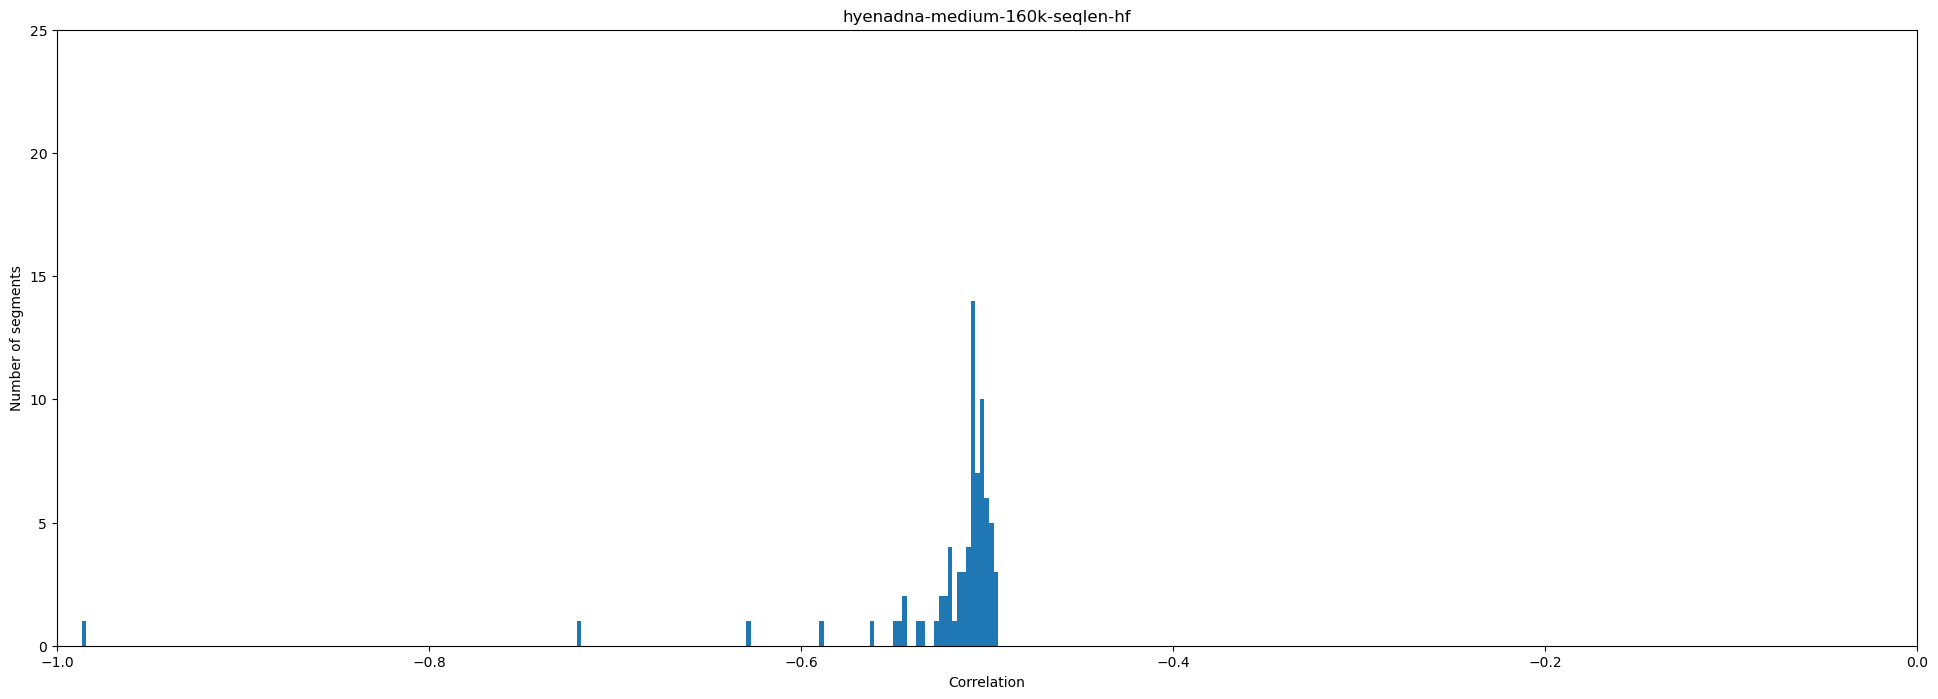

In [60]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.hist(corr, bins = 200)
ax.set_title("hyenadna-medium-160k-seqlen-hf")
ax.set(ylim=(0, 25), xlim = (-1, 0))
plt.xlabel('Correlation')
plt.ylabel('Number of segments')
plt.show()

Perhaps try getting the id of the segments which each segment have the least and most similarity with, and compare that with the same for the embeddings one?

## With Hamming scores of all strains

In [10]:
totalCorr = []

In [12]:
def hammingEuclidCorr(strain, model):
    euclidDistances = pd.read_csv(f"Alignment Scores/Embeddings/Euclid/{model}/{strain}_{maxLen}_euclidDistances.csv").to_numpy().flatten() #remember to change to maxLen here
    hammingScores = pd.read_csv(f"../../Sequence Alignment/Hamming Scores/{model}/{strain}_{maxLen}_hammingScores.csv").to_numpy().flatten()
    '''
    hammingScores, euclidDistances = pd.DataFrame(hammingScores), pd.DataFrame(euclidDistances) #just so that I can use .corrwith; which gives pearson correlation column-wise :)
    return hammingScores.corrwith(euclidDistances)[0] #same as hammingScores[0].corr(euclidDistances[0])
    '''
    return stats.pearsonr(euclidDistances, hammingScores) #returns the Pearson product-moment correlation coefficient (same as above) and the pvalue

In [14]:
hammingEuclidCorr('AAA', 'DNABERT-2')

PearsonRResult(statistic=0.006464469909876691, pvalue=5.469353843140416e-15)

In [ ]:
hammingEuclidCorr('AAA', 'hyena450')

In [15]:
for strain in strains:
    totalCorr.append(hammingEuclidCorr(strain, 'DNABERT-2')[0]) #index 0 for correlation, 1 for pvalue

### hyena 160k:

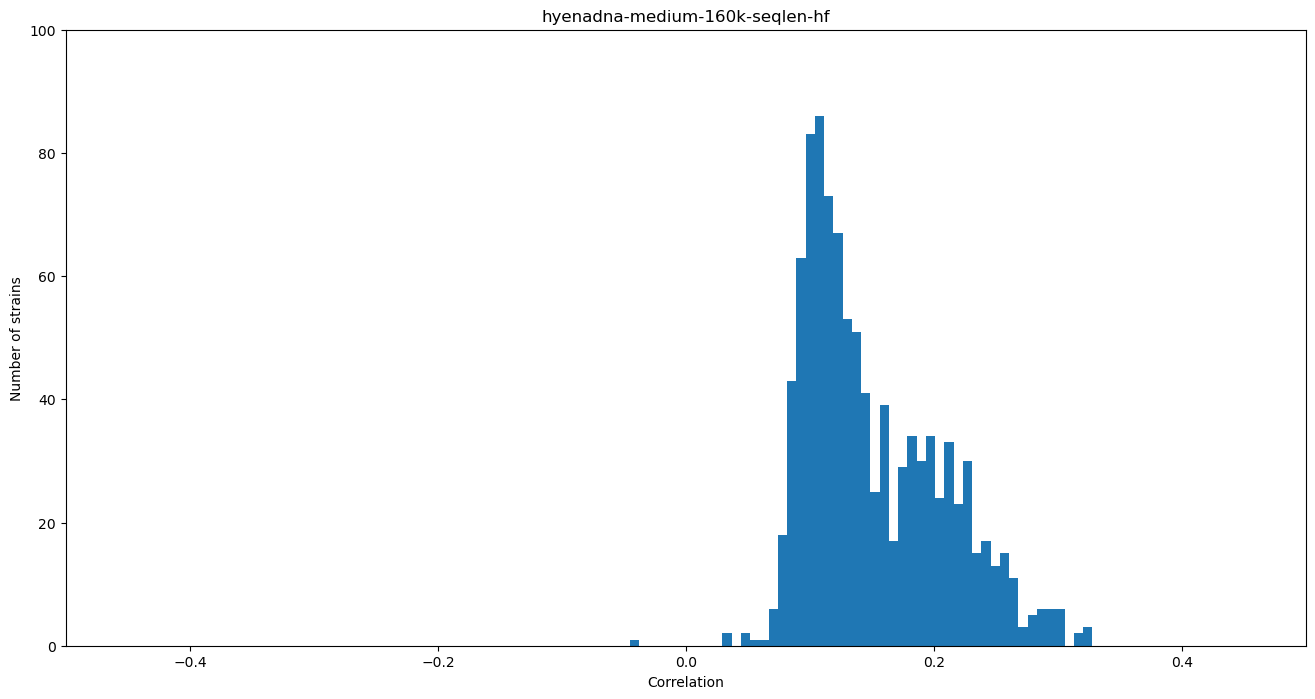

In [89]:
#Using pandas' corrwith/ scipy pearsonr's statistic
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(totalCorr, bins = 50)
ax.set_title("hyenadna-medium-160k-seqlen-hf")
ax.set(ylim=(0, 100), xlim = (-0.5, 0.5))
plt.xlabel('Correlation')
plt.ylabel('Number of strains')
plt.show()

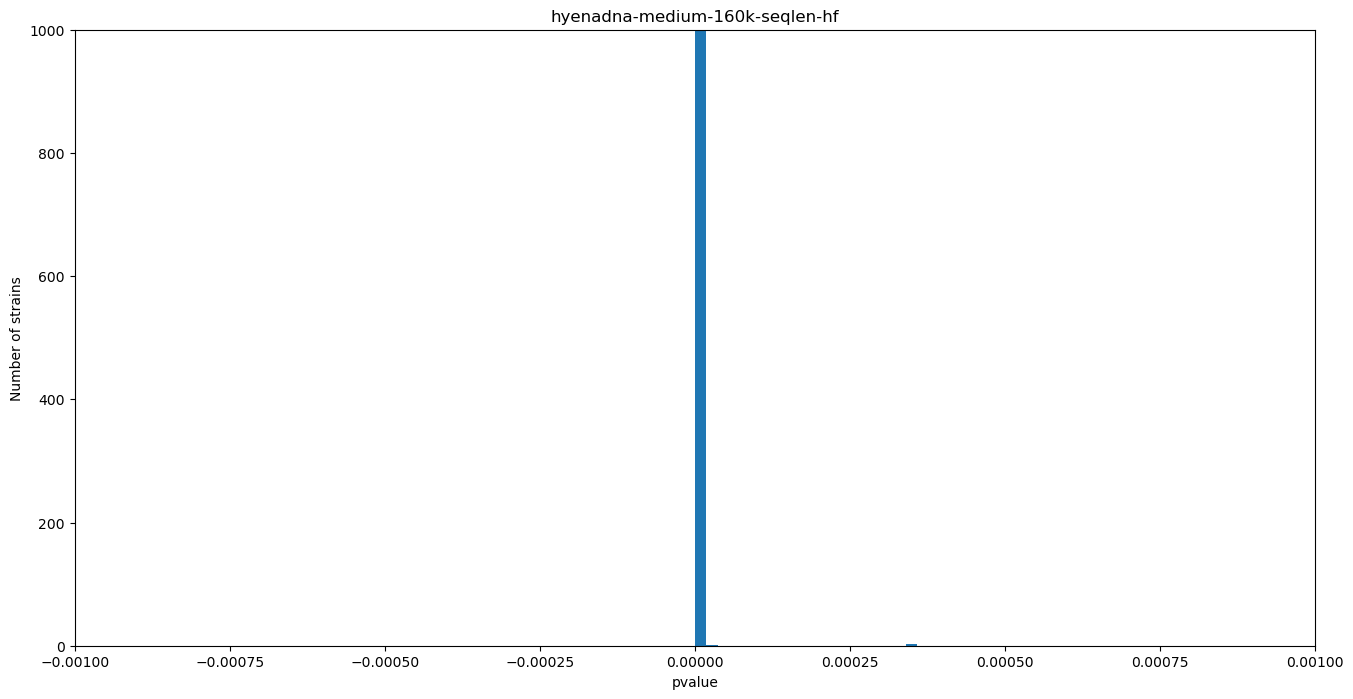

In [109]:
#Using pearsonr's pvalues 
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(totalCorr, bins = 1000)
ax.set_title("hyenadna-medium-160k-seqlen-hf")
ax.set(ylim= (0, 1000), xlim = (-0.001, 0.001))
plt.xlabel('pvalue')
plt.ylabel('Number of strains')
plt.show()

### hyena 450k:

In [16]:
hammingEuclidCorr('AAA', 'hyena450')

PearsonRResult(statistic=0.0207429595272216, pvalue=0.2455331035567907)

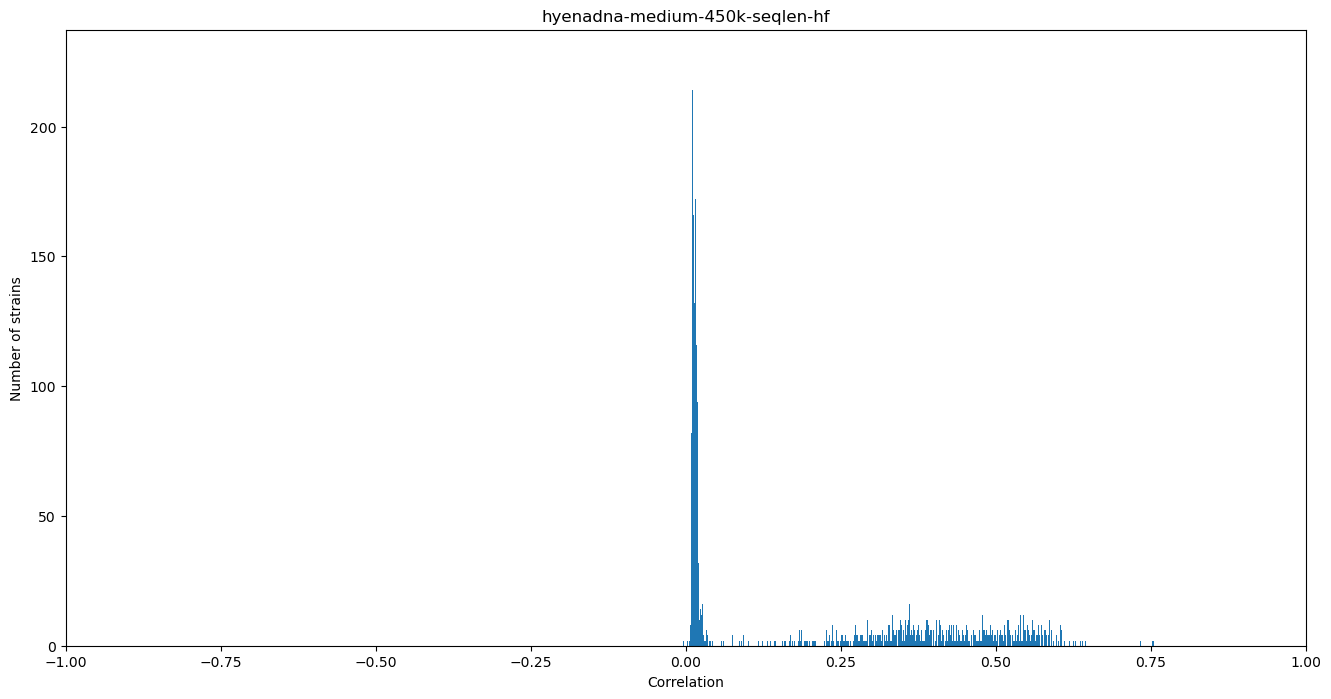

In [31]:
#Using pearsonr's pvalues 
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(totalCorr, bins = 1000)
ax.set_title("hyenadna-medium-450k-seqlen-hf")
ax.set(xlim = (-1, 1))
plt.xlabel('Correlation')
plt.ylabel('Number of strains')
plt.show()

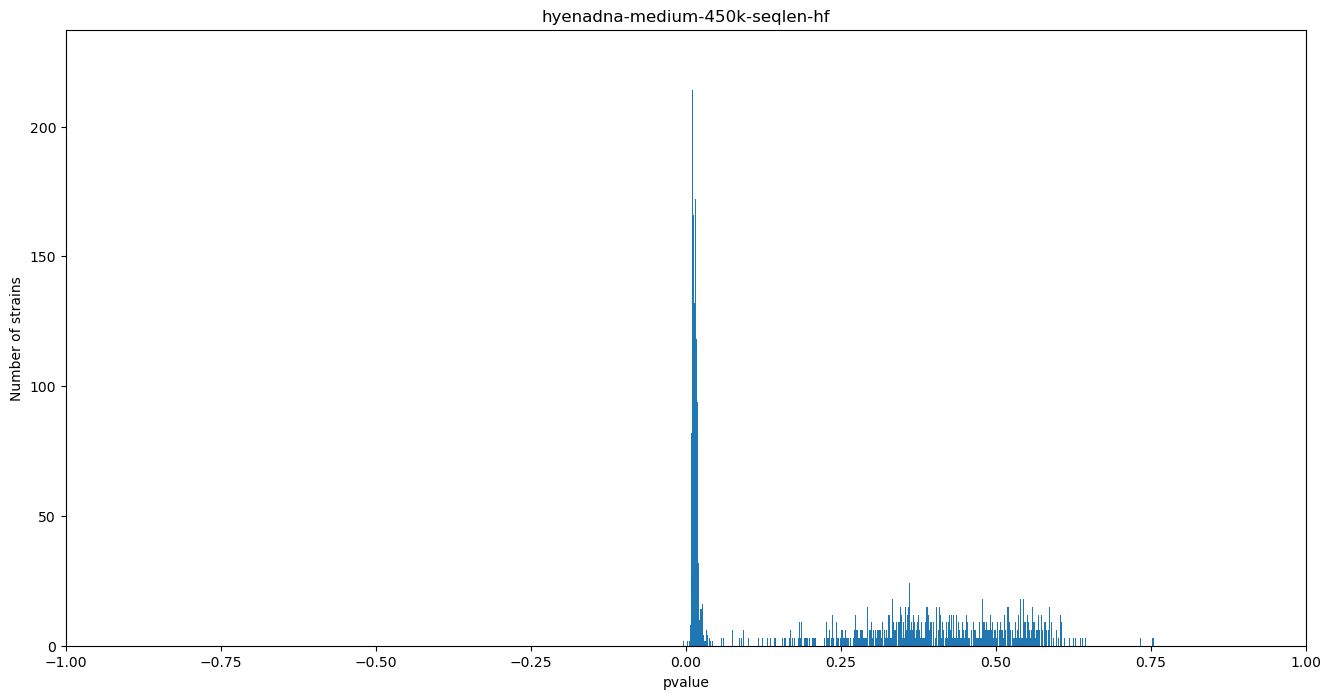

In [34]:
#Using pandas' corrwith/ scipy pearsonr's statistic
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(totalCorr, bins = 1000)
ax.set_title("hyenadna-medium-450k-seqlen-hf")
ax.set(xlim = (-1, 1))
plt.xlabel('pvalue')
plt.ylabel('Number of strains')
plt.show()

### DNABERT-2

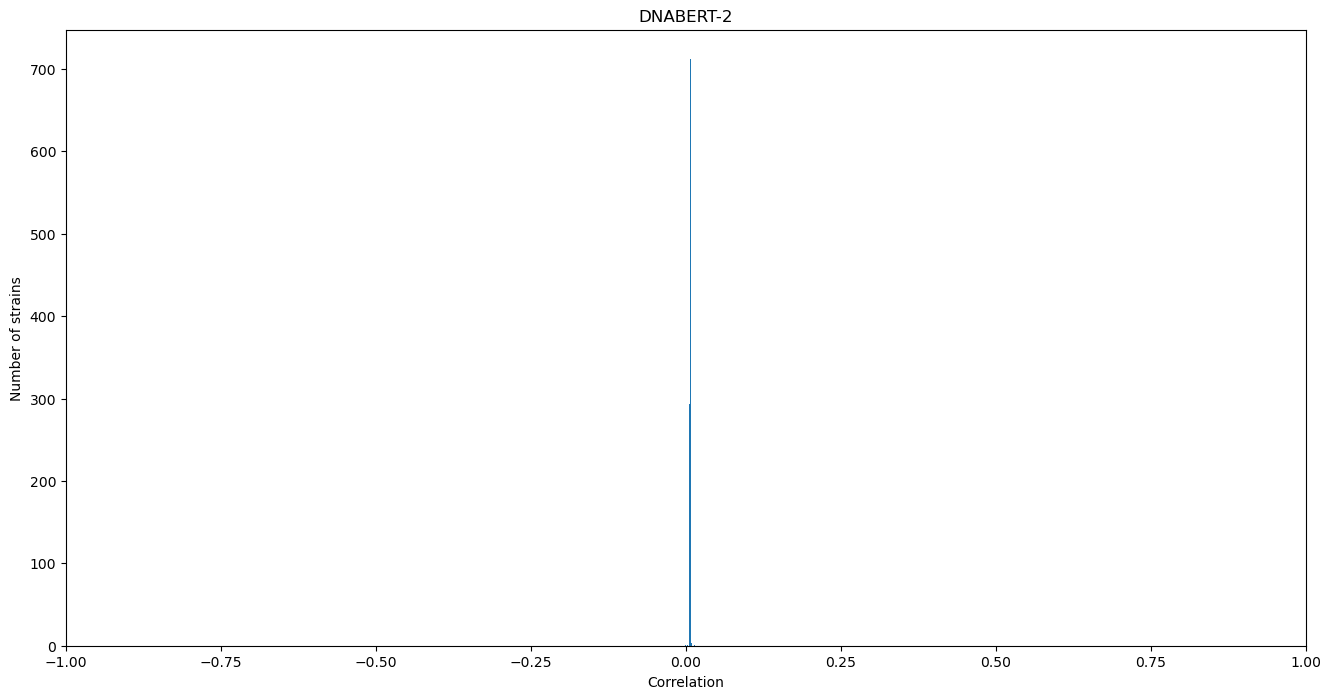

In [18]:
#Using pearsonr's pvalues 
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(totalCorr, bins = 10)
ax.set_title("DNABERT-2")
ax.set(xlim = (-1, 1))
plt.xlabel('Correlation')
plt.ylabel('Number of strains')
plt.show()

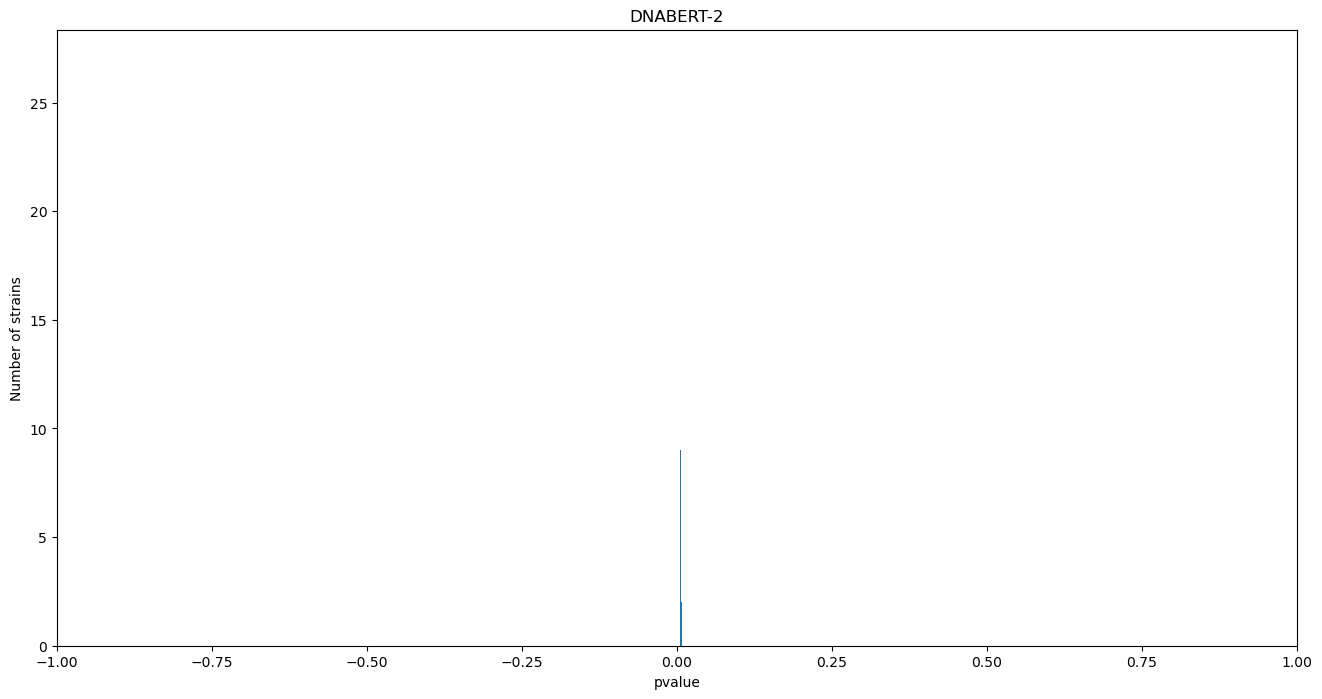

In [17]:
#Using pandas' corrwith/ scipy pearsonr's statistic
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(totalCorr, bins = 1000)
ax.set_title("DNABERT-2")
ax.set(xlim = (-1, 1))
plt.xlabel('pvalue')
plt.ylabel('Number of strains')
plt.show()

pvalue represents the probability of a non-zero correlation being due to randomness in the data.